Loading the essential datasets

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import datasets
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory

Loading the data


In [3]:
import zipfile

# Specify the path to your ZIP file
zip_file_path = '/content/Brain tumor.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/BTE'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [5]:
image_list = []

for img_path in glob.iglob("/content/BTE/Brain Tumor Data Set/Brain Tumor Data Set/*/*.jpg"):
    img = Image.open(img_path)
    image_list.append(np.asarray(img))

image_array = np.asarray(image_list, dtype="object")

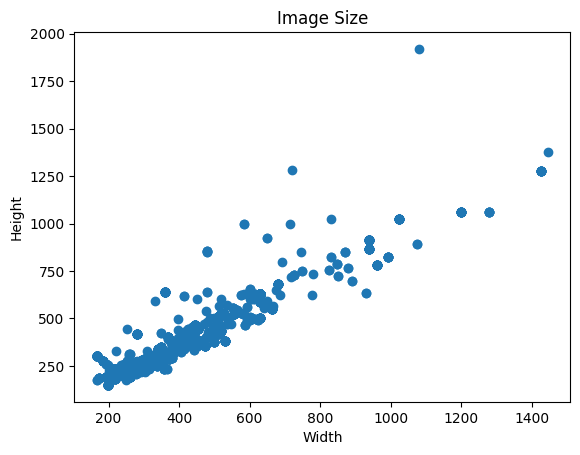

In [6]:
import numpy as np
import matplotlib.pyplot as plt

image_sizes_X = []
image_sizes_Y = []

for i in range(image_array.shape[0]):
    image_sizes_X.append(image_array[i].shape[0])
    image_sizes_Y.append(image_array[i].shape[1])

image_sizes_X = np.asarray(image_sizes_X)
image_sizes_Y = np.asarray(image_sizes_Y)

plt.scatter(image_sizes_X, image_sizes_Y)
plt.title("Image Size")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


In [7]:
avg_width = np.mean(image_sizes_X).astype("int32")
avg_height = np.mean(image_sizes_Y).astype("int32")
image_size = (avg_width, avg_height)
image_size


(381, 362)

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "/content/BTE/Brain Tumor Data Set/Brain Tumor Data Set/",
    labels="inferred",
    image_size=image_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=16
)

validation_dataset = image_dataset_from_directory(
    "/content/BTE/Brain Tumor Data Set/Brain Tumor Data Set/",
    labels="inferred",
    image_size=image_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=16
)


Found 4514 files belonging to 2 classes.
Using 3160 files for training.
Found 4514 files belonging to 2 classes.
Using 1354 files for validation.


In [9]:
classes = train_dataset.class_names
classes


['Brain Tumor', 'Healthy']

DATA VISUALIZATION

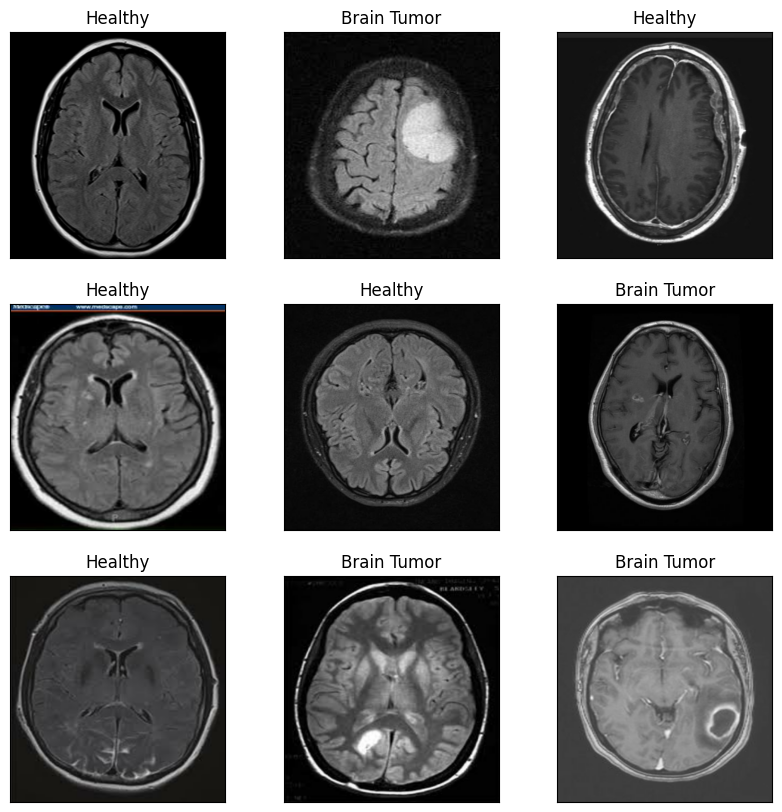

In [10]:
for images, labels in train_dataset.take(1):
    figs, axs = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        temp = 3*i
        for j in range(3):
            index = temp + j
            axs[i][j].imshow(images[index].numpy().astype("int32"))
            axs[i][j].set_title(classes[labels[index]])
            axs[i][j].set_xticks(ticks=[])
            axs[i][j].set_yticks(ticks=[])


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


MODEL WE SELECTED APRE-TRAINED MODEL OF VGG16

In [12]:
image_shape = image_size + (3,)


In [13]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights="imagenet",
                                               input_shape=image_shape)
base_model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 381, 362, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 381, 362, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 381, 362, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 190, 181, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 190, 181, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 190, 181, 128)     147584    
                                                              

In [14]:
def tumor_classifier(input_shape):
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=input_shape)
    base_model.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [15]:
model = tumor_classifier(input_shape=image_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 381, 362, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 381, 362, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 381, 362, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 381, 362, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 61952)             0     

Training the model

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 10
history = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs)


Epoch 1/10
99/99 [==============================] - 81s 643ms/step - loss: 0.6684 - accuracy: 0.6272 - val_loss: 0.5773 - val_accuracy: 0.6617
Epoch 2/10
99/99 [==============================] - 49s 490ms/step - loss: 0.6066 - accuracy: 0.6693 - val_loss: 0.5926 - val_accuracy: 0.6573
Epoch 3/10
99/99 [==============================] - 50s 497ms/step - loss: 0.5470 - accuracy: 0.6994 - val_loss: 0.5792 - val_accuracy: 0.6603
Epoch 4/10
99/99 [==============================] - 50s 504ms/step - loss: 0.5407 - accuracy: 0.7019 - val_loss: 0.5337 - val_accuracy: 0.6869
Epoch 5/10
99/99 [==============================] - 50s 504ms/step - loss: 0.5082 - accuracy: 0.7225 - val_loss: 0.5314 - val_accuracy: 0.7075
Epoch 6/10
99/99 [==============================] - 49s 492ms/step - loss: 0.5590 - accuracy: 0.6981 - val_loss: 0.5223 - val_accuracy: 0.6839
Epoch 7/10
99/99 [==============================] - 49s 489ms/step - loss: 0.4931 - accuracy: 0.7297 - val_loss: 0.5181 - val_accuracy: 0.6809

In [17]:
len(base_model.layers)

19

In [18]:
def fine_tuned_model(input_shape, num_frozen_layers):
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   weights="imagenet",
                                                   include_top=False)
    base_model.trainable = True
    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [21]:
num_frozen_layers = 7
model = fine_tuned_model(input_shape=image_shape, num_frozen_layers=num_frozen_layers)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 381, 362, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 381, 362, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 381, 362, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 381, 362, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 1024)      4719

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 10
history = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs)


Epoch 1/10
99/99 [==============================] - 130s 1s/step - loss: 1.5992 - accuracy: 0.5864 - val_loss: 124.1439 - val_accuracy: 0.4586
Epoch 2/10
99/99 [==============================] - 93s 930ms/step - loss: 0.9581 - accuracy: 0.6522 - val_loss: 27.1999 - val_accuracy: 0.4586
Epoch 3/10
99/99 [==============================] - 96s 964ms/step - loss: 1.0208 - accuracy: 0.6247 - val_loss: 81.9209 - val_accuracy: 0.4586
Epoch 4/10
99/99 [==============================] - 91s 916ms/step - loss: 0.7207 - accuracy: 0.6956 - val_loss: 72.1323 - val_accuracy: 0.4586
Epoch 5/10
99/99 [==============================] - 89s 896ms/step - loss: 0.7081 - accuracy: 0.7127 - val_loss: 10.4022 - val_accuracy: 0.4586
Epoch 6/10
99/99 [==============================] - 90s 909ms/step - loss: 0.5988 - accuracy: 0.7370 - val_loss: 6.0522 - val_accuracy: 0.4586
Epoch 7/10
99/99 [==============================] - 90s 904ms/step - loss: 0.4973 - accuracy: 0.7687 - val_loss: 5.2556 - val_accuracy: 0.

In [23]:
epochs = 20
history2 = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs, initial_epoch=history.epoch[-1])


Epoch 10/20
99/99 [==============================] - 90s 905ms/step - loss: 0.5751 - accuracy: 0.7797 - val_loss: 51.5746 - val_accuracy: 0.5414
Epoch 11/20
99/99 [==============================] - 90s 902ms/step - loss: 0.5159 - accuracy: 0.8063 - val_loss: 13.0680 - val_accuracy: 0.5414
Epoch 12/20
99/99 [==============================] - 90s 903ms/step - loss: 0.5968 - accuracy: 0.7911 - val_loss: 33.8107 - val_accuracy: 0.5414
Epoch 13/20
99/99 [==============================] - 93s 930ms/step - loss: 0.5655 - accuracy: 0.8047 - val_loss: 42.5975 - val_accuracy: 0.5414
Epoch 14/20
99/99 [==============================] - 96s 964ms/step - loss: 0.4754 - accuracy: 0.8247 - val_loss: 19.1672 - val_accuracy: 0.4586
Epoch 15/20
99/99 [==============================] - 96s 963ms/step - loss: 0.3682 - accuracy: 0.8522 - val_loss: 2.4342 - val_accuracy: 0.6034
Epoch 16/20
99/99 [==============================] - 96s 964ms/step - loss: 0.3911 - accuracy: 0.8465 - val_loss: 23.1410 - val_acc

ERROR ANALYSIS

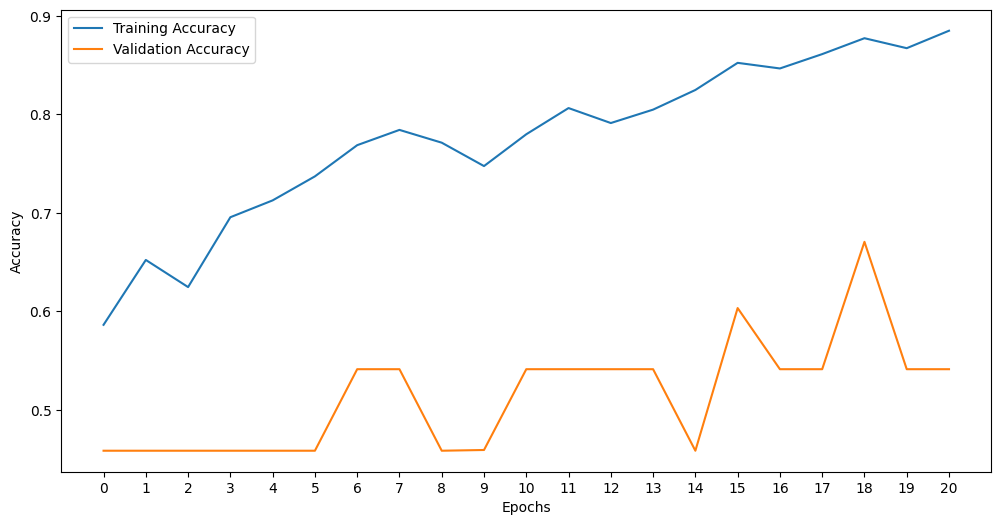

In [24]:
acc = history.history["accuracy"] + history2.history["accuracy"]
val_acc = history.history["val_accuracy"] + history2.history["val_accuracy"]

plt.figure(figsize=(12,6))
plt.plot(range(epochs+1), acc, label="Training Accuracy")
plt.plot(range(epochs+1), val_acc, label="Validation Accuracy")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(list(range(epochs+1)))
plt.show()


In [25]:
def augment_data(input):
    x = tf.keras.layers.RandomFlip("horizontal")(input)
    output = tf.keras.layers.RandomRotation(0.1)(x)

    return output


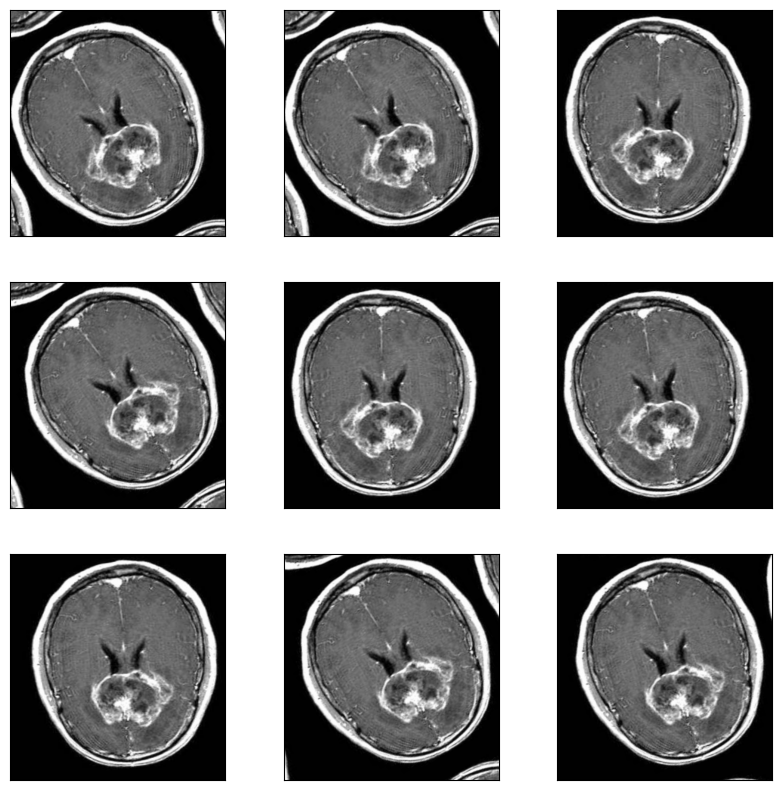

In [26]:
for images, labels in train_dataset.take(1):
    img = images[0]
    figs, axs = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        for j in range(3):
            augmented_img = augment_data(img)
            axs[i][j].imshow(augmented_img.numpy().astype("int32"))
            axs[i][j].set_xticks(ticks=[])
            axs[i][j].set_yticks(ticks=[])


In [27]:
def data_augmented_regularized_model(input_shape, num_freezed_layers):
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    base_model.trainable = True
    for layer in base_model.layers[:num_freezed_layers]:
        layer.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = augment_data(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [28]:
num_frozen_layers = 7
model = data_augmented_regularized_model(input_shape=image_shape, num_freezed_layers=num_frozen_layers)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 20
history = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs)


Epoch 1/20
99/99 [==============================] - 111s 1s/step - loss: 1.8527 - accuracy: 0.5165 - val_loss: 13.6772 - val_accuracy: 0.4586
Epoch 2/20
99/99 [==============================] - 109s 1s/step - loss: 0.8617 - accuracy: 0.5687 - val_loss: 34.9234 - val_accuracy: 0.4586
Epoch 3/20
99/99 [==============================] - 105s 1s/step - loss: 0.8703 - accuracy: 0.6484 - val_loss: 84.2635 - val_accuracy: 0.4586
Epoch 4/20
99/99 [==============================] - 105s 1s/step - loss: 0.8410 - accuracy: 0.6646 - val_loss: 42.5906 - val_accuracy: 0.4586
Epoch 5/20
99/99 [==============================] - 105s 1s/step - loss: 0.9565 - accuracy: 0.6402 - val_loss: 22.8999 - val_accuracy: 0.4586
Epoch 6/20
99/99 [==============================] - 104s 1s/step - loss: 0.7074 - accuracy: 0.6880 - val_loss: 3.0703 - val_accuracy: 0.4778
Epoch 7/20
99/99 [==============================] - 104s 1s/step - loss: 0.8588 - accuracy: 0.6766 - val_loss: 49.4450 - val_accuracy: 0.4586
Epoch 8

After the regularization and data augmentation. The validation accuracy doesnot increase. So as the VGG16 Model has toomany layers we tried building model with few layers

In [29]:
def Modfinal_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = augment_data(x)
    x = tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [30]:
model = Modfinal_model(input_shape=image_shape)
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 381, 362, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 381, 362, 3)       0         
                                                                 
 random_flip_10 (RandomFlip  (None, 381, 362, 3)       0         
 )                                                               
                                                                 
 random_rotation_10 (Random  (None, 381, 362, 3)       0         
 Rotation)                                                       
                                                                 
 conv2d_12 (Conv2D)          (None, 381, 362, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 190, 181, 16)      0   

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 20
history = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs)


Epoch 1/20
99/99 [==============================] - 28s 213ms/step - loss: 0.6398 - accuracy: 0.6152 - val_loss: 0.5534 - val_accuracy: 0.7142
Epoch 2/20
99/99 [==============================] - 19s 185ms/step - loss: 0.4683 - accuracy: 0.7585 - val_loss: 0.4348 - val_accuracy: 0.7614
Epoch 3/20
99/99 [==============================] - 18s 180ms/step - loss: 0.4049 - accuracy: 0.8066 - val_loss: 0.4159 - val_accuracy: 0.8235
Epoch 4/20
99/99 [==============================] - 20s 200ms/step - loss: 0.3477 - accuracy: 0.8329 - val_loss: 0.3244 - val_accuracy: 0.8508
Epoch 5/20
99/99 [==============================] - 19s 191ms/step - loss: 0.3129 - accuracy: 0.8563 - val_loss: 0.2604 - val_accuracy: 0.8892
Epoch 6/20
99/99 [==============================] - 19s 186ms/step - loss: 0.2800 - accuracy: 0.8756 - val_loss: 0.2530 - val_accuracy: 0.8700
Epoch 7/20
99/99 [==============================] - 20s 194ms/step - loss: 0.2278 - accuracy: 0.9060 - val_loss: 0.2344 - val_accuracy: 0.9055

In [33]:
model = Modfinal_model(image_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 30
history = model.fit(train_dataset, batch_size=32, validation_data=validation_dataset, epochs=epochs)


Epoch 1/30
99/99 [==============================] - 22s 181ms/step - loss: 0.6609 - accuracy: 0.6019 - val_loss: 0.5782 - val_accuracy: 0.6935
Epoch 2/30
99/99 [==============================] - 20s 195ms/step - loss: 0.5192 - accuracy: 0.7335 - val_loss: 0.4321 - val_accuracy: 0.8168
Epoch 3/30
99/99 [==============================] - 19s 188ms/step - loss: 0.4051 - accuracy: 0.7918 - val_loss: 0.3431 - val_accuracy: 0.8368
Epoch 4/30
99/99 [==============================] - 20s 194ms/step - loss: 0.3732 - accuracy: 0.8187 - val_loss: 0.3082 - val_accuracy: 0.8752
Epoch 5/30
99/99 [==============================] - 17s 172ms/step - loss: 0.3294 - accuracy: 0.8475 - val_loss: 0.2791 - val_accuracy: 0.8959
Epoch 6/30
99/99 [==============================] - 19s 184ms/step - loss: 0.3029 - accuracy: 0.8557 - val_loss: 0.2383 - val_accuracy: 0.9010
Epoch 7/30
99/99 [==============================] - 18s 179ms/step - loss: 0.2541 - accuracy: 0.8839 - val_loss: 0.2714 - val_accuracy: 0.8744

In [56]:
history.history['val_accuracy']

[0.6935007572174072,
 0.8168389797210693,
 0.8367798924446106,
 0.8751846551895142,
 0.8958641290664673,
 0.9010339975357056,
 0.8744460940361023,
 0.920236349105835,
 0.9313146471977234,
 0.9283604025840759,
 0.9335302710533142,
 0.9446085691452026,
 0.9290989637374878,
 0.9379615783691406,
 0.963810920715332,
 0.9652880430221558,
 0.9667651653289795,
 0.9667651653289795,
 0.9512555599212646,
 0.9741506576538086,
 0.9697193503379822,
 0.9741506576538086,
 0.9719350337982178,
 0.9689807891845703,
 0.9748892188072205,
 0.9519941210746765,
 0.9645494818687439,
 0.978581964969635,
 0.9689807891845703,
 0.9734120965003967]

In [57]:
history.history['accuracy']

[0.601898729801178,
 0.7335442900657654,
 0.7917721271514893,
 0.8186708688735962,
 0.847468376159668,
 0.8556962013244629,
 0.8838607668876648,
 0.8943037986755371,
 0.9082278609275818,
 0.9275316596031189,
 0.9287974834442139,
 0.9433544278144836,
 0.9484177231788635,
 0.9572784900665283,
 0.9636076092720032,
 0.9639240503311157,
 0.9693037867546082,
 0.9702531695365906,
 0.9734176993370056,
 0.9753164649009705,
 0.9765822887420654,
 0.9813291430473328,
 0.9750000238418579,
 0.9889240264892578,
 0.9857594966888428,
 0.9854430556297302,
 0.9838607311248779,
 0.9857594966888428,
 0.982594907283783,
 0.9810126423835754]

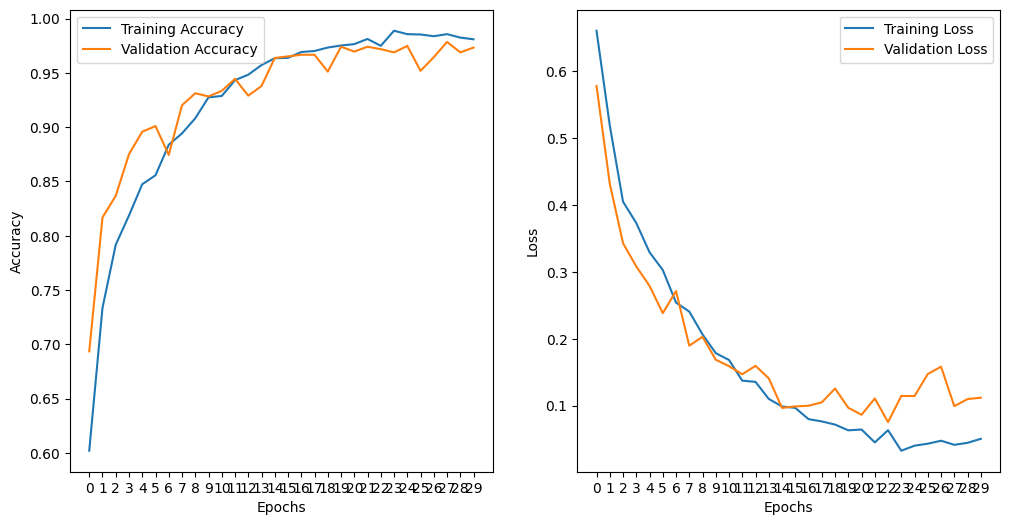

In [58]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

figs, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(epochs), acc, label="Training Accuracy")
axs[0].plot(range(epochs), val_acc, label="Validation Accuracy")
axs[0].legend(loc="upper left")
axs[0].set_xlabel("Epochs")
axs[0].set_xticks(list(range(epochs)))
axs[0].set_ylabel("Accuracy")
axs[1].plot(range(epochs), loss, label="Training Loss")
axs[1].plot(range(epochs), val_loss, label="Validation Loss")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Epochs")
axs[1].set_xticks(list(range(epochs)))
axs[1].set_ylabel("Loss")
plt.show()


In [59]:
img = tf.keras.utils.load_img("/content/scan.jpg", target_size=image_size)
img = np.asarray(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.math.sigmoid(prediction)
result = 1 if score > 0.5 else 0
confidence = float(score * 100) if result else float((1 - score) * 100)
print(f"The image belongs to class '{classes[result]}' with {confidence:.6f}% confidence.")


1/1 [==============================] - 0s 18ms/step
The image belongs to class 'Brain Tumor' with 100.000000% confidence.


In [60]:
img = tf.keras.utils.load_img("/content/scan2.png", target_size=image_size)
img = np.asarray(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.math.sigmoid(prediction)
result = 1 if score > 0.5 else 0
confidence = float(score * 100) if result else float((1 - score) * 100)
print(f"The image belongs to class '{classes[result]}' with {confidence:.6f}% confidence.")


1/1 [==============================] - 0s 28ms/step
The image belongs to class 'Healthy' with 100.000000% confidence.


In [61]:
model.save("brain_tumor_classifier.keras")